## Background

In the fastai course Part 1 [Lesson 6 video](https://youtu.be/AdhG64NF76E?feature=shared&t=3117) Jeremy Howard walked through the notebooks [First Steps: Road to the Top, Part 1](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1) and [Small models: Road to the Top, Part 2](https://www.kaggle.com/code/jhoward/small-models-road-to-the-top-part-2) where he builds increasingly accurate solutions to the [Paddy Doctor: Paddy Disease Classification](https://www.kaggle.com/competitions/paddy-disease-classification) Kaggle Competition. In the video, Jeremy referenced a series of walkthrough videos that he made while working through the four-notebook series for this competition. I'm excited to watch these walkthroughs to better understand how to approach a Kaggle competition from the perspective of a former #1 Kaggle grandmaster.

In this blog post series, I'll walk through the code Jeremy shared in each of the 6 Live Coding videos focused on this competition, submitting predictions to Kaggle along the way. My last two blog posts in this series reference Jeremy's [Scaling Up: Road to the Top, Part 3](https://www.kaggle.com/code/jhoward/scaling-up-road-to-the-top-part-3) notebook to improve my large model ensemble predictions. Here are the links to each of the blog posts in this series:

- [Part 1: Live Coding 8](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-1/)
- [Part 2: Live Coding 9](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-2/)
- [Part 3: Live Coding 10](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-3/)
- Part 4: Live Coding 11 (You are here)
- [Part 5: Live Coding 12](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-5/)
- [Part 6: Live Coding 13](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-6/)
- [Part 7: Improving My Large Ensemble, Part 1](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-7/)
- [Part 8: Improving My Large Ensemble, Part 2](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-8/)


[Link to the Live Coding 11 video](https://www.youtube.com/watch?v=j-zMF2VirA8)

## Setup

In [1]:
!pip install -qq timm==0.6.13
import timm
timm.__version__

'0.6.13'

In [2]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *
from fastai.vision.all import *

comp = 'paddy-disease-classification'
path = setup_comp(comp, install='fastai')

In [3]:
path.ls()

(#4) [Path('../input/paddy-disease-classification/sample_submission.csv'),Path('../input/paddy-disease-classification/train_images'),Path('../input/paddy-disease-classification/train.csv'),Path('../input/paddy-disease-classification/test_images')]

In [4]:
trn_path = path/'train_images'

## Recap on Paddy Competition

Jeremy submitted two more entries to the Paddy competition:

- Ensembled the models we had (improved the submission)
- Since the VIT models were better than the rest, doubled their weights (that improved it as well)

## Tips on getting votes for Kaggle notebooks

To get more Kaggle notebook votes, create them in response to a popular competition. Much harder to get votes for a notebook that's not part of a competition.

## Weights and Biases Sweep

In tmux, press shift+D and select a client to disconnect it (in order to removed dotted-background in terminal).

In Weights & Biases: you can run a "sweep" which runs lots of copies of your program feeding it different configurations. You can run the wandb client as many times as you want, setting it to a different CUDA device each time. Jeremy turns his model training routine into a python script, taking in arguments and passing them to a training function which initializes wandb using the given configuration, fine-tunes it, and does logging. NVIDIA tells you the GPU power usage (among other metrics). The key thing is the maximum memory use (`wandb.summary["GPU_mem"]`).

fastai has a thing called fastgpu which is a "queue service for quickly developing scripts that use all of your GPUs efficiently." wandb takes this much further.

Note: The information about your git repo is in `.git/config`.

wandb API gives access to the runs logs (list of dictionaries) that we can then chuck into a `DataFrame`.

Note: plotly has interactive [parallel coordinates plot](https://plotly.com/python/parallel-coordinates-plot/).

## Brute force hyperparameter optimisation vs human approach

In general, Jeremy doesn't do Bayesian hyperparameter stuff ever. Which is funny because he taught wandb about the method they use for hyperparameter optimization. Used it once specifically for finding a good set of dropouts for AWD_LSTM---coded a random forest that actually tries to predict how accurate something's going to be and then use that random forest to target better sets of hyperparameters. Jeremy likes to use a much more human-driven approach---what's the hypothesis I'm trying to test, how can I test that as fast as possible. Most hyperparameters are independent of other hyperparameters. You don't have to do a huge grid search. For example learning rate of 0.008 is always the best so let's not try every learning rate for every model for every resize type, etc., let's just use that learning rate. Same thing for resize method---crop was always better than squish for the few things we tried it on so we don't have to try every combination. Jeremy also feels that he learns a lot more about deep learning when he asks like what do I want to know about this thing? Or is that thing independent of that other thing? Or are they connected or not? Next time I do another project I can leverage the knowledge of what I've learnt rather than do yet another huge hyperparameter sweep. My brain is the thing that's learning. People at big companies that spend all of their time doing this big hyperparameter optimizations I always feel in talking to them they don't seem to know much about the practice of deep learning. Like they don't seem to know like what generally works and what generally doesn't work because they never bother trying to figure out the answers to those questions, but instead they just chuck in a huge hyperparameter optimization thing into a thousand GPUs.

Hyperparameters generalize across different architectures and models (see [this study](https://www.platform.ai/post/optimizing-hyperparams-for-image-datasets-in-fastai)). Across 90 different models they all had basically the same best learning rate (or close enough). This is true of computer vision, but not necessarily for tabular. All computer vision problems do all look pretty similar, the data for them looks pretty similar, Jeremy suspects that's also true of object recognition. Nobody seems to be testing this but we should do similar tests for segmentation, bounding boxes, and so forth. Jeremy's pretty sure we'd find the same thing.

## Learning rate finder

Jeremy hardly uses learning rate finder, hasn't mentioned it yet in this course. fastai learning rate default is a bit lower than the optimal just because Jeremy didn't want to push it, rather it always worked pretty well rather than be pretty much the best. 

## Debugging port issues with ps

Normally the Jupyter server uses port 8888, Jeremy only has his SSH server setup to forward to port 8888. The fact that it's using a different port, 8889, suggests that it's already running somewhere. To find out where it's running type `ps waux` to list all of your processes. To filter them to ones that contain jupyter or notebook: `ps waux | grep jupyter`.

## Background sessions in tmux

`tmux ls` lists all of your tmux sessions. `Ctrl+Z` to put a job into the background (and also stops the job), `fg` to bring it into the foreground. If you type `bg` (and optionally followed the job number, defaults to the last job put into the background) it will run the last job put in the background. It will still print output even if it's in the background. Jeremy doesn't so this very much because if he wants to run a job at the same time as the other he chucks it into another tmux pane. If you run something with `&` at the end, it always runs it in the background. To run processes in parallel put an `&` after each one. To kill a process type `fg` to foreground it and then type `Ctrl+C`. See [bash job control](https://www.gnu.org/software/bash/manual/html_node/Job-Control-Basics.html) for more information. The job number has a `%` at the start.

From wikipedia: _tmux is an open-source terminal multiplexer for Unix-like operating systems. It allows multiple terminal sessions to be accessed simultaneously in a single window. It is useful for running more than one command-line program at the same time._

## Strategy for iterating between notebooks

When Jeremy iterates through notebooks, what he tends to do is that once he's got something vaguely working, he generally duplicates it and then tries to get something else vaguely working (change a parameter, try a different method, etc.), and once that starts vaguely working, he renames it. Then, from time to time, he cleans up the duplicated notebook versions that he didn't end up using and he can tell which ones those are because he hasn't renamed them yet (`paddy_base_Copy1.ipynb`, `paddy_base_Copy2.ipynb`, etc.).

In this case, Jeremy started out with `paddy.ipynb`, and just experimented (`show_batch`, `lr_find` and try to get something running). From that he dupicated it (`paddy_Copy1.ipynb`). In that he wanted to try different architectures, batch transforms and item transforms so he created a `train` function which takes those three things, creates a set of `ImageDataLoaders` with those transforms, use a fixed `seed` to get the same validation set each time (to compare performance across architectures), train it with an architecture, and then return the tta error rate. He then goes through the notebook trying different small architectures (small so they will run decently quickly), batch and item transforms. From that he gets a sense of which batch and item transforms work well for which architectures.  He renames this notebook`paddy-small.ipynb`.

Jeremy is looking at two things: error rate at the end of training and tta error rate. The main one he cares about is the tta error rate since that's the one he's going to end up using.

If you pass an `int` instead of a `tuple` to item or batch transforms' `size` parameter it will resize to a square.

Most frameworks (at the time of this video) doesn't provide a test time augmentation method (except for one unnamed group that copies everything from fastai).

The cool kids on Kaggle (at the time of this videoin 2022) use `swin2`, which has fixed resolution and for larger model sizes has image size options of 192 and 256.

None of the `crop` resize method runs were doing well for vit or swin2, but were doing well for convnext.

## Building an ensemble - appending predictions

Jeremy then duplicated `paddy_small.ipynb`, picked the models that performed well (and delete the rest), and did a search and replace of `small` with `large`. He got rid of the fixed random `seed` when creating the `ImageDataLoaders` in the `train` function, giving a different training set each time (meaning the models will not be comparable, which is fine). Jeremy appends to an empty starting list `tta_res` the tta predictions from each model. 

For the very last Kaggle entry: Jeremy took the two best models (in his case the ViTs) and appending their tta predictions to the list `tta_res` so that they were there twice. A slightly clunky way of doing a weighted average. Then he stacked them all together, took the mean of the predictions, found the argmax (index of the class with the largest prediction) and then submit in the same way as before. This is Jeremy's process which is not particularly thoughtful, but rather mechanical, which is what he likes about it as it can probably be automated. 

## Model stacking

Question: how critical is model stacking in Kaggle? Next time we'll submit just the best ViT predictions and compare it to the stacked predictions. That will give us a sense of how much the ensembling matters. 

For convnext: the large ensemble model had half the error rate of the small single model.

## Keeping track of submission notebooks

Question: how do you keep track of which submissions are tied to which notebook? Jeremy just provides a small description to the submission to remind him. A better approach would be to actually write the notebook name there, which is what Jeremy normally does. Don't change those notebooks after submission, duplicate them, make changes in the duplicate and rename them to something sensible. This all ends up back in github. Using this approach you will actually become a better deep learning practitioner. There are very few people who actually use this approach and there are very few people Jeremy comes across who are actually good deep learning practitioners. Not many people seem to know what works and what doesn't.

The only way Jeremy can do this approach (small number of models) is because of already running a lot of models prior and logging their performance.

---

## Training Large Models

After going through walkthrough 11, I'll now imitate the same approach Jeremy used and create an ensemble of models for my next Kaggle submission.

I'll train the large versions of the following three small models (and transforms), which performed the best on TTA error rate:

|Architecture|item_tfms|batch_tfms|Error Rate (First Run)|Minutes (per epoch)|
|:-|:-|:-|:-|:-|
|swinv2_base_window12_192_22k|`Resize(480, method='squish')`|`aug_transforms(size=192, min_scale=0.75)`|0.0163*|02:30
|convnext_small_in22k|`Resize((640,480))`|`aug_transforms(size=(288,224), min_scale=0.75)`|0.0178*|01:51
|vit_small_patch16_224|`Resize(480)`|`aug_transforms(size=224, min_scale=0.75)`|0.0202*|00:44


I'll prepare a helper function which does all the submission csv prep stuff:

In [17]:
def prep_submission(fn, tta_res):
    # pull out predictions from tta_res list
    tta_prs = first(zip(*tta_res))
    
    # convert tta_res from list to stacked tensor
    t_tta = torch.stack(tta_prs)
    
    # take mean of each item's predictions
    avg_pr = t_tta.mean(0)
    
    # get the index (class) of the maximum prediction for each item
    idxs = avg_pr.argmax(dim=1)
    
    # create DataLoaders to get its vocab
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=Resize(224))
    
    # convert indexes to vocab strings
    mapping = dict(enumerate(dls.vocab))
    
    # add vocab strings to sample submission file and export to CSV
    ss = pd.read_csv(path/'sample_submission.csv')
    results = pd.Series(idxs.numpy(), name='idxs').map(mapping)
    ss.label = results
    ss.to_csv(fn, index=False)

I'll also copy from the above the `train` function defined by Jeremy that I'll use for these models---instead of handling the tta predictions inside the training function, I'm returning the `Learner` and the `DataLoaders` so that I can calculate the validation set error rate and prep the test `DataLoader` with the appropriate `Resize` based on the model.

In [8]:
tta_res = []

In [9]:
def train(arch, item, batch, accum=False):
    kwargs = {'bs': 16} if accum else {}
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=item, batch_tfms=batch, **kwargs)
    cbs = GradientAccumulation(2) if accum else []
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
    learn.fine_tune(12, 0.01)
    return learn, dls
    # tta_res.append(learn.tta(dl=tst_dl))
    # return error_rate(*learn.tta(dl=dls.valid))

Now I'll train the three large models:

In [10]:
arch = 'swinv2_large_window12_192_22k'

In [11]:
learn, dls = train(arch, item=Resize(480, method='squish'), batch=aug_transforms(size=192, min_scale=0.75), accum=True)

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)

  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

Downloading: "https://github.com/SwinTransformer/storage/releases/download/v2.0.0/swinv2_large_patch4_window12_192_22k.pth" to /root/.cache/torch/hub/checkpoints/swinv2_large_patch4_window12_192_22k.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.212364,0.643707,0.188852,03:40


epoch,train_loss,valid_loss,error_rate,time
0,0.476209,0.274359,0.094666,05:01
1,0.494529,0.300078,0.098030,05:01
2,0.447107,0.328064,0.099952,05:01
3,0.429720,0.298238,0.089861,05:02
4,0.284891,0.312586,0.082172,05:02
5,0.248839,0.156329,0.039885,05:02
6,0.132434,0.122389,0.039404,05:01
7,0.114585,0.123687,0.031235,05:01
8,0.078405,0.103234,0.027871,05:01
9,0.061866,0.087151,0.022105,05:01


Here's the code to prepare the test `DataLoader` for this swin model that uses 192x192 pixels:

In [12]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=Resize(192))
tst_files = get_image_files(path/'test_images')
tst_files.sort()
tst_dl = dls.test_dl(tst_files)

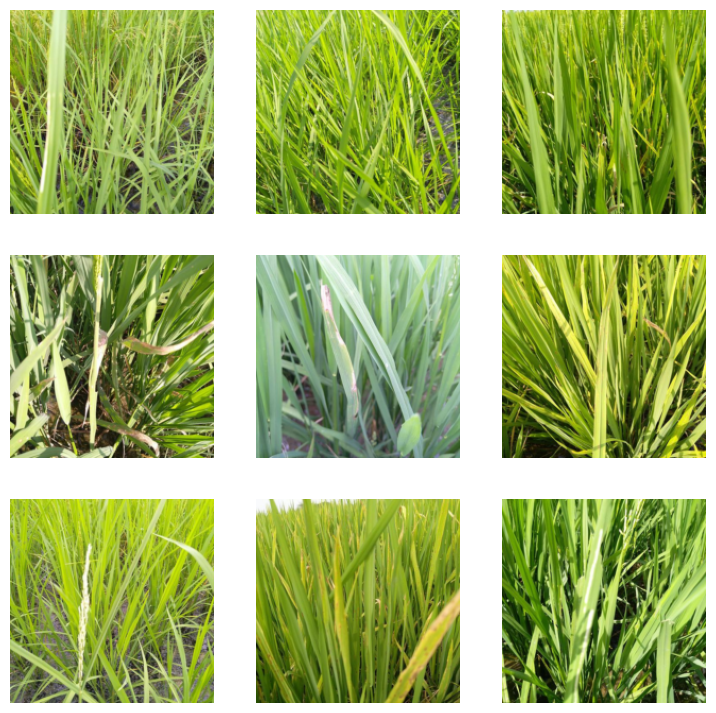

In [13]:
tst_dl.show_batch()

In [14]:
tta_res.append(learn.tta(dl=tst_dl))

In [15]:
len(tta_res[0][0])

3469

In [16]:
error_rate(*learn.tta(dl=dls.valid))

TensorBase(0.0159)

In [17]:
arch = 'convnext_large_in22k'

In [18]:
learn, dls = train(arch, item=Resize((640,480)), batch=aug_transforms(size=(288,224), min_scale=0.75), accum=True)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_large_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.213938,0.805596,0.224892,03:14


epoch,train_loss,valid_loss,error_rate,time
0,0.467912,0.239441,0.077367,04:48
1,0.419594,0.247392,0.067756,04:47
2,0.377958,0.205914,0.062470,04:45
3,0.312134,0.294184,0.071600,04:46
4,0.233862,0.241724,0.058626,04:46
5,0.149694,0.118743,0.028832,04:45
6,0.141486,0.137468,0.030274,04:45
7,0.086328,0.117887,0.027391,04:45
8,0.069587,0.101186,0.024027,04:45
9,0.047381,0.083770,0.017780,04:44


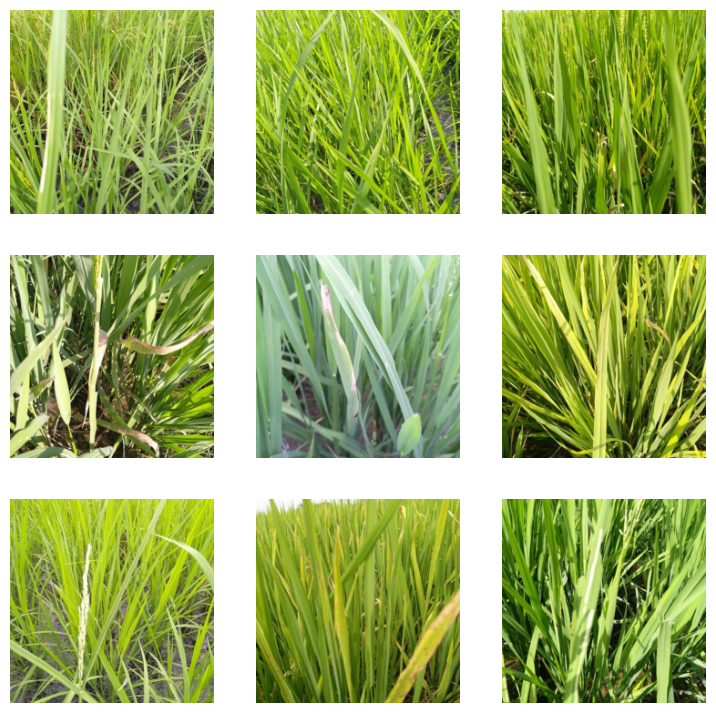

In [19]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=Resize(224))
tst_files = get_image_files(path/'test_images')
tst_files.sort()
tst_dl = dls.test_dl(tst_files)
tst_dl.show_batch()

In [20]:
tta_res.append(learn.tta(dl=tst_dl))

In [21]:
len(tta_res), len(tta_res[0][0]), len(tta_res[1][0])

(2, 3469, 3469)

In [22]:
error_rate(*learn.tta(dl=dls.valid))

TensorBase(0.0706)

In [23]:
arch = 'vit_large_patch16_224'

In [24]:
learn, dls = train(arch, item=Resize(480), batch=aug_transforms(size=224, min_scale=0.75), accum=True)

epoch,train_loss,valid_loss,error_rate,time
0,1.303628,0.769040,0.225853,04:53


epoch,train_loss,valid_loss,error_rate,time
0,0.472007,0.282628,0.092263,06:47
1,0.493476,0.508031,0.155694,06:48
2,0.510523,0.543362,0.172994,06:46
3,0.449807,0.509493,0.131667,06:46
4,0.323358,0.229533,0.068236,06:46
5,0.239007,0.150215,0.044210,06:46
6,0.223845,0.160197,0.047093,06:45
7,0.085320,0.112214,0.029313,06:45
8,0.078987,0.108103,0.029313,06:46
9,0.043259,0.092681,0.024507,06:45


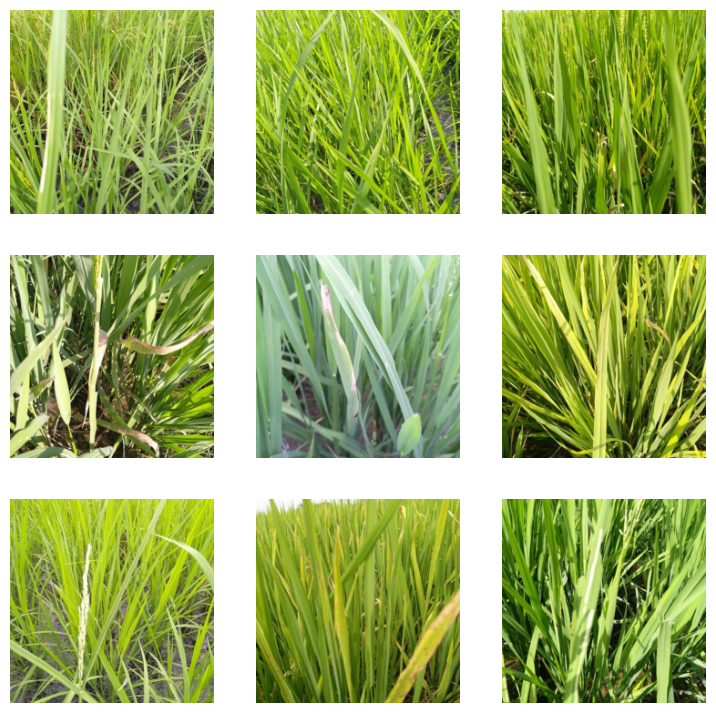

In [25]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=Resize(224))
tst_files = get_image_files(path/'test_images')
tst_files.sort()
tst_dl = dls.test_dl(tst_files)
tst_dl.show_batch()

In [26]:
tta_res.append(learn.tta(dl=tst_dl))

In [27]:
len(tta_res), len(tta_res[0][0]), len(tta_res[1][0]), len(tta_res[2][0])

(3, 3469, 3469, 3469)

In [28]:
error_rate(*learn.tta(dl=dls.valid))

TensorBase(0.0135)

In [42]:
prep_submission('subm_large_ensemble.csv', tta_res)

In [43]:
!head subm_large_ensemble.csv

image_id,label

200001.jpg,hispa

200002.jpg,normal

200003.jpg,blast

200004.jpg,blast

200005.jpg,blast

200006.jpg,brown_spot

200007.jpg,dead_heart

200008.jpg,brown_spot

200009.jpg,hispa


### Improving the Large Model Ensemble

Here is a summary of my submissions so far in this competition, with the fifth submission the one I just did with a large model ensemble:

|Submission|Description|Private Score|Public Score|
|:-:|:-|:-:|:-:|
|1|initial submission file after creating a quick small model following Jeremy Howard's walkthrough video.|0.13709|0.12418|
|2|initial submission using convnext small 2 epochs fine-tuned sorted file list|0.94124|0.92541|
|3|squish convnext small 12 epoch ft tta|0.98156|0.98308|
|4|ensemble small 12 epoch ft tta|0.98617|0.98423|
|5|swinv2 convnext vit large ensemble 12 epoch ft tta|0.97811|0.98039|


The first four submissions were going great---each successive one improved the private and public score. I was expecting my ensemble with larger models to improve the accuracy of the small model ensemble. Instead, the larger ensemble's private error rate (1-0.97811) is 58% more than the smaller ensemble (1-0.98617), and the public error rate of the larger ensemble (1-0.98039) is 24% larger than the smaller ensemble (1-0.98423). Why?

## Improving the Large Model Ensemble

In order to try and improve the large model ensemble, I want to share my main observation from the large model training runs: In each of the training runs, the error rate increased for the first 4-5 epochs before decreasing, and was higher after the final epoch than any of the final error rates of the smaller models. I think this means that I should train the models for longer. Granted, the error rates between the larger models and between the larger and smaller models are not comparable (they use different validation sets), so I can't conclude anything about training performance from that comparison. However, I would generally expect the error rates of the larger models to be lower, even on different validation sets (perhaps that's not a fair expectation).

A secondary observation that I made is that the manner in which I calculated the TTA error rate after each training run...

```python
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=Resize(224))
tst_files = get_image_files(path/'test_images')
tst_files.sort()
tst_dl = dls.test_dl(tst_files)

error_rate(*learn.tta(dl=dls.valid))
```
...is not correct. I should pass `dls.valid` using the `dls` used during the training to `learn.tta` instead of using a new `DataLoaders` object which has a different training/validation split, and therefore likely is including images from the training when calculating the error rate. I also should use the same item and batch transforms.

I'll redefine my `train` function to include the TTA prediction and error rate calculations, and increase the number of epochs to 24 (this will likely be too large, but I'll adjust after one training run):

In [6]:
# run this once and re-use for all trainings
tst_files = get_image_files(path/'test_images')
tst_files.sort()

In [7]:
def train(arch, item, batch, accum=False):
    kwargs = {'bs': 16} if accum else {}
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=item, batch_tfms=batch, **kwargs)
    cbs = GradientAccumulation(2) if accum else []
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
    learn.fine_tune(24, 0.01)
    
    # view losses
    learn.recorder.plot_loss()
    
    # TTA predictions using test dataset
    tst_dl = dls.test_dl(tst_files)
    tta_res.append(learn.tta(dl=tst_dl))
    
    # Return error rate using validation dataset
    print(error_rate(*learn.tta(dl=dls.valid)))
    return learn, dls

### Determine Ideal Number of Epochs

I'll train the swinv2 model to see how many epochs I should use for training---I'll be keeping an eye on the validation loss. If it starts to increase, I know I've trained for too long. 

**I'll train it a few times to see how stable the training is.**

In [12]:
tta_res = []

In [13]:
arch = 'swinv2_large_window12_192_22k'

In [54]:
train(arch, item=Resize(480, method='squish'), batch=aug_transforms(size=192, min_scale=0.75), accum=True)

epoch,train_loss,valid_loss,error_rate,time
0,1.242866,0.766052,0.219606,03:40


epoch,train_loss,valid_loss,error_rate,time
0,0.439101,0.294660,0.087938,05:01
1,0.351378,0.222908,0.068236,05:02
2,0.362053,0.194189,0.060548,05:02
3,0.352330,0.217729,0.064873,05:02
4,0.317429,0.332206,0.088419,05:02
5,0.268157,0.211638,0.057184,05:02
6,0.281623,0.222969,0.059587,05:02
7,0.302056,0.192562,0.053820,05:02
8,0.240952,0.229510,0.058626,05:02
9,0.121465,0.183262,0.040365,05:02


TensorBase(0.0187)

I'm getting decent results after 24 epochs. Let's see if that holds when I train it again:

In [58]:
learn, dls = train(arch, item=Resize(480, method='squish'), batch=aug_transforms(size=192, min_scale=0.75), accum=True)

epoch,train_loss,valid_loss,error_rate,time
0,1.092984,0.851812,0.221048,03:40


epoch,train_loss,valid_loss,error_rate,time
0,0.544550,0.254801,0.083614,05:01
1,0.348117,0.210600,0.066795,05:02
2,0.360428,0.211086,0.065834,05:02
3,0.346224,0.313809,0.094666,05:02
4,0.368918,0.243433,0.067756,05:02
5,0.377717,0.414140,0.119654,05:02
6,0.310699,0.225722,0.069678,05:01
7,0.245260,0.207003,0.061028,05:01
8,0.183680,0.181822,0.049976,05:01
9,0.138067,0.211188,0.052859,05:01


TensorBase(0.0154)


I get a similar final error rate as the first training. However, it's not so clear from the tables how the validation and training losses change over the course of the training. To do so, I've added `learn.recorder.plot_loss()` to the `train` function.

I'll train it a couple more times to see the loss plots (_ignore the `NameError` for now, I'm not concerned with TTA error rate at this point, I'm only concerned with whether or not the training is stable_):

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)

  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

Downloading: "https://github.com/SwinTransformer/storage/releases/download/v2.0.0/swinv2_large_patch4_window12_192_22k.pth" to /root/.cache/torch/hub/checkpoints/swinv2_large_patch4_window12_192_22k.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.294445,0.719873,0.204229,03:42


epoch,train_loss,valid_loss,error_rate,time
0,0.485149,0.264520,0.084575,05:08
1,0.383336,0.238155,0.072081,05:07
2,0.322685,0.196292,0.052379,05:06
3,0.391429,0.196975,0.056223,05:06
4,0.310772,0.311188,0.084575,05:07
5,0.370088,0.309966,0.087458,05:07
6,0.306135,0.160217,0.045651,05:06
7,0.227858,0.303918,0.077367,05:08
8,0.237295,0.202838,0.050937,05:08
9,0.173179,0.163243,0.046132,05:08


NameError: name 'tst_files' is not defined

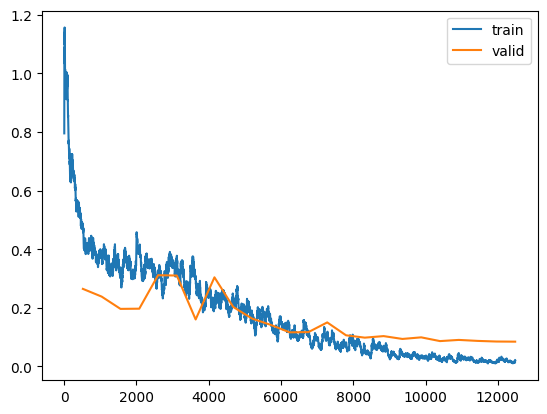

In [11]:
learn, dls = train(arch, item=Resize(480, method='squish'), batch=aug_transforms(size=192, min_scale=0.75), accum=True)

In [ ]:
tta_res = []

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)

  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

Downloading: "https://github.com/SwinTransformer/storage/releases/download/v2.0.0/swinv2_large_patch4_window12_192_22k.pth" to /root/.cache/torch/hub/checkpoints/swinv2_large_patch4_window12_192_22k.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.327175,0.800045,0.214320,03:41


epoch,train_loss,valid_loss,error_rate,time
0,0.428933,0.264715,0.085536,05:10
1,0.373618,0.269784,0.081211,05:10
2,0.322864,0.236708,0.076406,05:10
3,0.318025,0.255129,0.073522,05:11
4,0.362358,0.276745,0.073042,05:10
5,0.252548,0.238884,0.056223,05:10
6,0.269222,0.258998,0.067275,05:11
7,0.232486,0.361521,0.095627,05:10
8,0.194597,0.210730,0.060067,05:10
9,0.195712,0.128107,0.036040,05:10


TensorBase(0.0183)


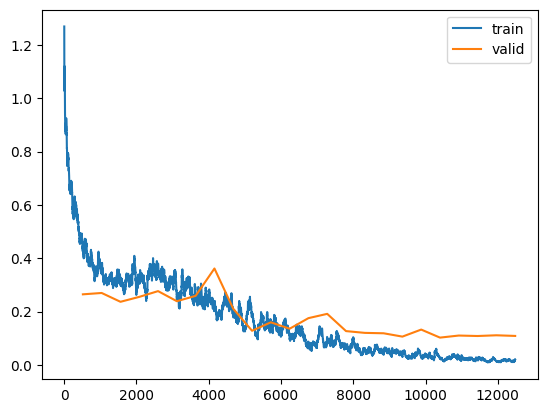

In [14]:
learn, dls = train(arch, item=Resize(480, method='squish'), batch=aug_transforms(size=192, min_scale=0.75), accum=True)

In [18]:
len(tta_res), len(tta_res[0][0])

(1, 3469)

I ran four training runs of 24 epochs each for this large swinv2 model, including two training runs where I plotted the validation and training loss. I noticed the same patterns in each one:

- The training and validation losses are generally decreasing but tend to rise and fall a bit across the training.
- 24 epochs doesn't seem to be overfitting the model. The validation loss certainly fluctuates a bit at the end of the training (increasing and decreasing in consecutive epochs) but it is relatively flat at the end. Perhaps I'm making a mistake here, and such a flattening is a sign of the start of overfitting, but I'm going to stick to 24 epochs for now.
- The final error rate during training is still unremarkable at around 0.02. None of the training runs resulted in anything close to the lowest error rate I had with smaller models (0.0163). Again, different validation sets will result in different error rates, but because of this lack of error rate improvement, I'm not expecting to improve my competition score significantly.

Next, I'll train the other two large models for 24 epochs each:

In [21]:
arch = 'convnext_large_in22k'

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_large_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.117779,0.660938,0.174916,03:27


epoch,train_loss,valid_loss,error_rate,time
0,0.437924,0.200062,0.068717,05:09
1,0.315851,0.158929,0.048054,05:10
2,0.294190,0.167008,0.049976,05:09
3,0.240635,0.133045,0.040846,05:09
4,0.296416,0.199445,0.057184,05:10
5,0.223830,0.155541,0.044690,05:09
6,0.231965,0.144504,0.034118,05:09
7,0.176270,0.160164,0.041807,05:09
8,0.173444,0.175411,0.039885,05:09
9,0.154608,0.150472,0.040846,05:09


TensorBase(0.0144)


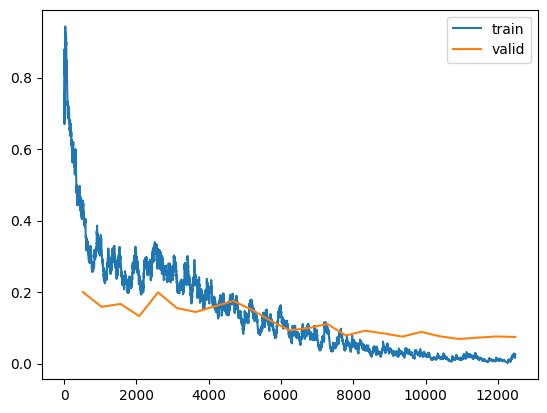

In [22]:
learn, dls = train(arch, item=Resize((640,480)), batch=aug_transforms(size=(288,224), min_scale=0.75), accum=True)

In [38]:
len(tta_res), len(tta_res[0][0]), len(tta_res[1][0])

(2, 3469, 3469)

Similar to the large swinv2 training run, the training loss starts at a much higher value and ends up at a lower value than the validation loss. Both losses fluctuate, decreasing for the first few epochs, then increasing in epoch 4, then generally decreasing the rest of the way with small bumps.

It's hard not to compare error rates across models, even though I know I shouldn't because they are on different validation and test sets. That being said:

After the final (24th) epoch, the large convnext model achieved about 30% smaller final training error rate than the large swinv2 models. The TTA error rate for convnext model (0.0144) is 20% lower than the swinv2 models (0.0183). 

Let's see how the large vit model performs, but I am leaning towards excluding the swinv2 model from the ensemble since it seems to be the worst performing one on both validation and test set error rates. I am now also questioning whether the excellent performance of the small swinv2 model just simply doesn't translate to the larger model. I also have to question here---am I doing something wrong in how I'm training these large models? Shouldn't they be performing much better than their smaller counterparts? convnext certainly seems to be doing so, but swinv2 doesn't.

In [10]:
arch = 'vit_large_patch16_224'

I was running into the usual CUDA Out-Of-Memory errors, even after restarting the kernel, so I found the following code online to clear out most of the GPU cache.

In [36]:
import gc; gc.collect()
torch.cuda.empty_cache()

epoch,train_loss,valid_loss,error_rate,time
0,1.293154,0.675305,0.199423,05:01


epoch,train_loss,valid_loss,error_rate,time
0,0.559790,0.329836,0.110524,07:00
1,0.347774,0.223555,0.070159,07:01
2,0.375485,0.274702,0.074003,07:01
3,0.386415,0.247032,0.070159,07:01
4,0.401717,0.207438,0.068236,07:01
5,0.367362,0.319452,0.100432,07:01
6,0.300632,0.215864,0.066314,07:01
7,0.232857,0.152640,0.044690,07:01
8,0.268405,0.222575,0.062470,07:01
9,0.139751,0.270562,0.072561,07:01


TensorBase(0.0197)


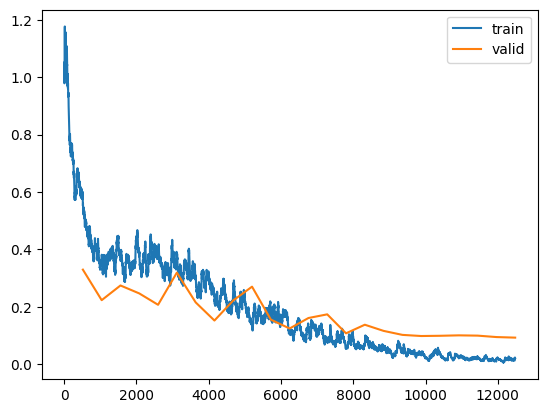

In [11]:
learn, dls = train(arch, item=Resize(480), batch=aug_transforms(size=224, min_scale=0.75), accum=True)

In [12]:
len(tta_res), len(tta_res[0][0]), len(tta_res[1][0]), len(tta_res[2][0])

(3, 3469, 3469, 3469)

Only the larger convnext model seems to be clearly out-performing its smaller counterpart. The larger swinv2 and vit models seems to be performing at around the same error rate as their smaller versions. I'll make my next submission an ensemble of these three models and see how it performs:

In [18]:
prep_submission('subm_large_ensemble2.csv', tta_res)

In [19]:
!head subm_large_ensemble2.csv

image_id,label

200001.jpg,hispa

200002.jpg,normal

200003.jpg,blast

200004.jpg,blast

200005.jpg,blast

200006.jpg,brown_spot

200007.jpg,dead_heart

200008.jpg,brown_spot

200009.jpg,hispa


The submission (the sixth submission in the table below) for this ensemble received a lower private score and a higher public score when compared to the best submission (Submission 4: ensemble of small models trained for 12 epochs with final predictions calculated using TTA), and higher private and public score when compared to the same ensemble trained on only 12 epochs.

|Submission|Description|Private Score|Public Score|
|:-:|:-|:-:|:-:|
|1|initial submission file after creating a quick small model following Jeremy Howard's walkthrough video.|0.13709|0.12418|
|2|initial submission using convnext small 2 epochs fine-tuned sorted file list|0.94124|0.92541|
|3|squish convnext small 12 epoch ft tta|0.98156|0.98308|
|4|ensemble small 12 epoch ft tta|0.98617|0.98423|
|5|swinv2 convnext vit large ensemble 12 epoch ft tta|0.97811|0.98039|
|6|swinv2 convnext vit large ensemble 24 epoch ft tta|0.98502|0.98539|

During training, the model with the lowest error rate was convnext_large_in22k. I'll weigh this model's predictions more (by duplicating them twice more) so the ratio between this model's predictions and the other models is 3:1, and see if that performs better.

In [34]:
tta_res += 2 * [tta_res[1]]

In [35]:
len(tta_res), len(tta_res[0][0]), len(tta_res[1][0]), len(tta_res[2][0]), len(tta_res[3][0]), len(tta_res[4][0])

(5, 3469, 3469, 3469, 3469, 3469)

In [36]:
prep_submission('subm_large_ensemble3.csv', tta_res)

In [37]:
!head subm_large_ensemble3.csv

image_id,label

200001.jpg,hispa

200002.jpg,normal

200003.jpg,blast

200004.jpg,blast

200005.jpg,blast

200006.jpg,brown_spot

200007.jpg,dead_heart

200008.jpg,brown_spot

200009.jpg,hispa


This submission (#7) actually decreased both the public and private scores:

|Submission|Description|Private Score|Public Score|
|:-:|:-|:-:|:-:|
|1|initial submission file after creating a quick small model following Jeremy Howard's walkthrough video.|0.13709|0.12418|
|2|initial submission using convnext small 2 epochs fine-tuned sorted file list|0.94124|0.92541|
|3|squish convnext small 12 epoch ft tta|0.98156|0.98308|
|4|ensemble small 12 epoch ft tta|0.98617|0.98423|
|5|swinv2 convnext vit large ensemble 12 epoch ft tta|0.97811|0.98039|
|6|swinv2 convnext vit large ensemble 24 epoch ft tta|0.98502|0.98539|
|7|swinv2 (3x convnext) vit large ensemble 24 epoch ft tta|0.98387|0.98423|

I'll try 5 more submissions next:

- 3:1 ratio between swinv2 and the other models
- 3:1 ratio between vit and the other models
- large swinv2 only
- large convnext only
- large vit only


In [39]:
# triple swinv2
tta_res = load_pickle('/kaggle/working/tta_res2.pkl')
tta_res += 2 * [tta_res[0]]
len(tta_res), len(tta_res[0][0]), len(tta_res[1][0]), len(tta_res[2][0]), len(tta_res[3][0]), len(tta_res[4][0])

(5, 3469, 3469, 3469, 3469, 3469)

In [40]:
prep_submission('subm_large_ensemble4.csv', tta_res)
!head subm_large_ensemble4.csv

image_id,label

200001.jpg,hispa

200002.jpg,normal

200003.jpg,blast

200004.jpg,blast

200005.jpg,blast

200006.jpg,brown_spot

200007.jpg,dead_heart

200008.jpg,brown_spot

200009.jpg,hispa


In [41]:
# triple vit
tta_res = load_pickle('/kaggle/working/tta_res2.pkl')
tta_res += 2 * [tta_res[2]]
len(tta_res), len(tta_res[0][0]), len(tta_res[1][0]), len(tta_res[2][0]), len(tta_res[3][0]), len(tta_res[4][0])

(5, 3469, 3469, 3469, 3469, 3469)

In [42]:
prep_submission('subm_large_ensemble5.csv', tta_res)
!head subm_large_ensemble5.csv

image_id,label

200001.jpg,hispa

200002.jpg,normal

200003.jpg,blast

200004.jpg,blast

200005.jpg,blast

200006.jpg,brown_spot

200007.jpg,dead_heart

200008.jpg,brown_spot

200009.jpg,hispa


In [45]:
# large swinv2 only
tta_res = load_pickle('/kaggle/working/tta_res2.pkl')
tta_res = [tta_res[0]]
len(tta_res), len(tta_res[0][0])

(1, 3469)

In [46]:
prep_submission('subm_large_swinv2.csv', tta_res)
!head subm_large_swinv2.csv

image_id,label

200001.jpg,hispa

200002.jpg,normal

200003.jpg,blast

200004.jpg,blast

200005.jpg,blast

200006.jpg,brown_spot

200007.jpg,dead_heart

200008.jpg,brown_spot

200009.jpg,hispa


In [47]:
# large convnext only
tta_res = load_pickle('/kaggle/working/tta_res2.pkl')
tta_res = [tta_res[1]]
len(tta_res), len(tta_res[0][0])

(1, 3469)

In [48]:
prep_submission('subm_large_convnext.csv', tta_res)
!head subm_large_convnext.csv

image_id,label

200001.jpg,hispa

200002.jpg,normal

200003.jpg,blast

200004.jpg,blast

200005.jpg,blast

200006.jpg,brown_spot

200007.jpg,dead_heart

200008.jpg,brown_spot

200009.jpg,hispa


In [49]:
# large vit only
tta_res = load_pickle('/kaggle/working/tta_res2.pkl')
tta_res = [tta_res[2]]
len(tta_res), len(tta_res[0][0])

(1, 3469)

In [50]:
prep_submission('subm_large_vit.csv', tta_res)
!head subm_large_vit.csv

image_id,label

200001.jpg,hispa

200002.jpg,normal

200003.jpg,blast

200004.jpg,blast

200005.jpg,blast

200006.jpg,brown_spot

200007.jpg,dead_heart

200008.jpg,brown_spot

200009.jpg,hispa


Here is the final summary of the public and private scores for each submission:

|Submission|Description|Private Score|Public Score|
|:-:|:-|:-:|:-:|
|1|initial submission file after creating a quick small model following Jeremy Howard's walkthrough video.|0.13709|0.12418|
|2|initial submission using convnext small 2 epochs fine-tuned sorted file list|0.94124|0.92541|
|3|squish convnext small 12 epoch ft tta|0.98156|0.98308|
|4|ensemble small 12 epoch ft tta|0.98617*|0.98423|
|5|swinv2 convnext vit large ensemble 12 epoch ft tta|0.97811|0.98039|
|6|swinv2 convnext vit large ensemble 24 epoch ft tta|0.98502|0.98539**|
|7|swinv2 (3x convnext) vit large ensemble 24 epoch ft tta|0.98387|0.98423|
|8|(3x swinv2) convnext vit large ensemble 24 epoch ft tta|0.98156|0.985|
|9|swinv2 convnext (3x vit) large ensemble 24 epoch ft tta|0.98617*|0.98462|
|10|swinv2 large 24 epoch ft tta|0.98271|0.98269|
|11|convnext large 24 epoch ft tta|0.98502|0.98269|
|12|vit large 24 epoch ft tta|0.97811|0.98231|


\* largest private score

\*\* largest public score

The two ensembles with the largest private score (0.98617) which I would therefore consider my best submissions:

- Three small models (swinv2, convnext, vit) trained for 12 epochs with predictions calculated using TTA.
- Three large models (swinv2, convnext, vit) trained for 24 epochs with predictions calculated using TTA and with a weighted average using 3 times the vit model's predictions.

I would have expected the larger models trained on more epochs to have a higher private and public score than their smaller versions trained on half the number of epochs.

In my [next blog post](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-5/) I walk through the discussion and code from Live Coding 12. I continue improving my large ensemble in [Part 7](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-7/) of this blog post series.